In [1]:
from utils import *

In [2]:
keys = ['date', 'symbol']

volumes = (
    pl.scan_csv('volumes.csv')
    .rename({'Date': keys[0]})
    .with_columns([pl.col(keys[0]).cast(pl.Date), pl.exclude(keys[0]).cast(pl.Float64)])
    .melt(id_vars=keys[0], variable_name=keys[1], value_name='volume')
    .drop_nulls('volume')
    .sort(keys)
    .collect()
)
assert volumes.null_count().sum_horizontal().item() == 0
# volumes.write_parquet('volumes.parquet')

# ('date', 'symbol') are unique keys

In [3]:
assert are_keys(volumes, keys)[0]

In [4]:
folded = fold(volumes, *keys)
full_index_per_symbol = get_full_index_per_symbol(folded, *keys)
volumes_full = full_index_per_symbol.join(volumes, how='left', on=keys)

volumes_wo_weekends = (
    volumes_full
    .filter(pl.col('date').dt.weekday().is_in([6, 7]).not_())
)

In [5]:
volumes.select(pl.col('date').n_unique(), pl.col('symbol').n_unique())

shape: (1, 2)
┌──────┬────────┐
│ date ┆ symbol │
│ ---  ┆ ---    │
│ u32  ┆ u32    │
╞══════╪════════╡
│ 5284 ┆ 1121   │
└──────┴────────┘

# Stocks with negative volumes

In [6]:
len(volumes_full.filter(pl.col('volume') < 0))

0

In [7]:
symbols = volumes_full.filter(pl.col('volume') < 0).get_column('symbol').unique()

In [8]:
for symbol in symbols:
    sub = volumes_full.filter(pl.col('symbol') == symbol).select(keys[0], 'volume')
    plot_ts(sub, keys[0])

# Stocks with low coverage

In [9]:
volumes.group_by('symbol').len().filter(pl.col('len') < 252 // 2).sort('len')

shape: (11, 2)
┌────────┬─────┐
│ symbol ┆ len │
│ ---    ┆ --- │
│ str    ┆ u32 │
╞════════╪═════╡
│ ACG    ┆ 1   │
│ AVG    ┆ 1   │
│ FGL    ┆ 1   │
│ AI     ┆ 16  │
│ MIG    ┆ 21  │
│ CRC    ┆ 45  │
│ SNOW   ┆ 75  │
│ DCT    ┆ 97  │
│ MEG    ┆ 113 │
│ BNK    ┆ 113 │
│ DHG    ┆ 123 │
└────────┴─────┘

# Coverages

<Figure size 900x500 with 0 Axes>

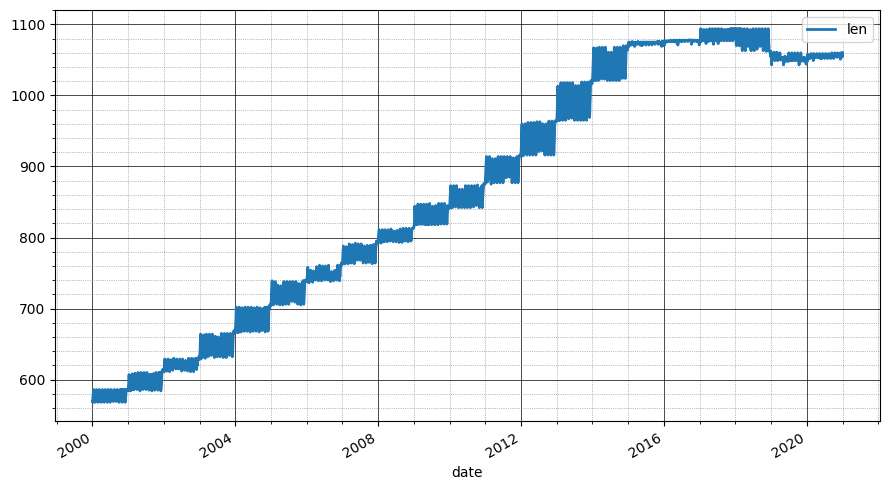

In [10]:
coverage = (
    volumes
    .drop_nulls('volume')
    .group_by('date', maintain_order=True)
    .len()
)
plot_ts(coverage, keys[0])

<Figure size 900x500 with 0 Axes>

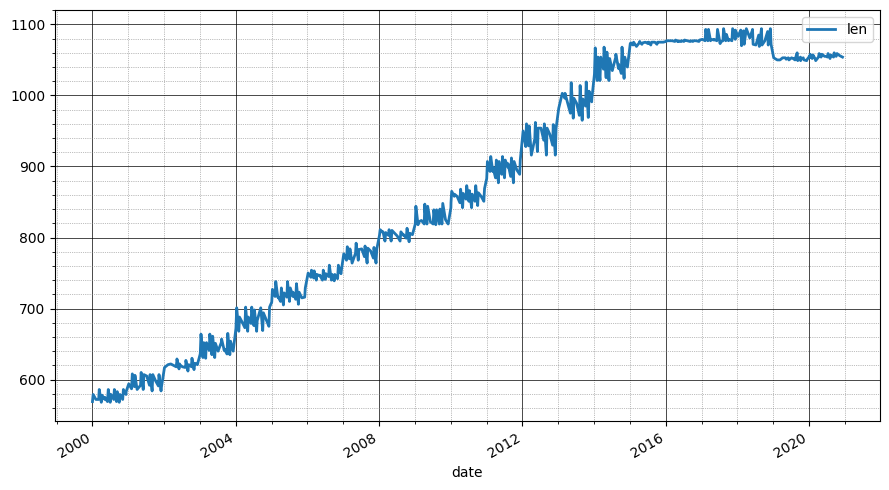

In [11]:
# on week_ends
coverage = (
    volumes
    .drop_nulls('volume')
    .filter(pl.col('date').dt.weekday().is_in([6, 7]))
    .group_by('date', maintain_order=True)
    .len()
)
plot_ts(coverage, keys[0])

<Figure size 900x500 with 0 Axes>

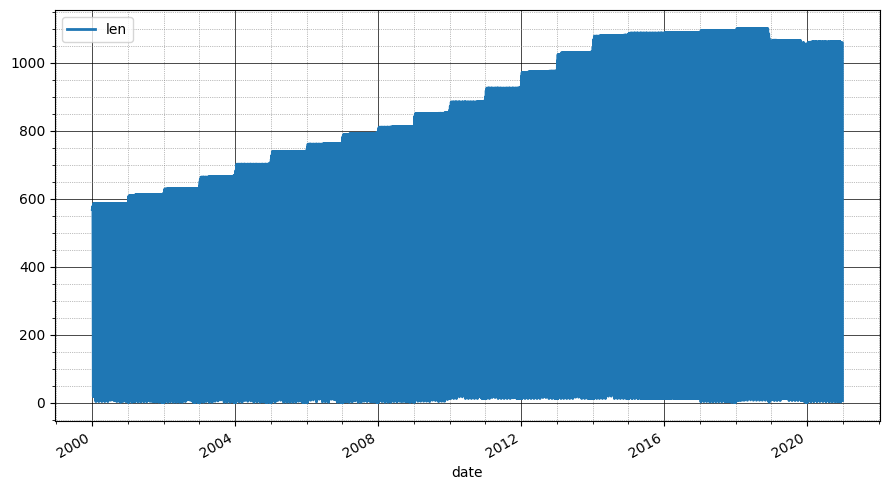

In [12]:
# dates without data for any stock
uncovered = (
    volumes_full
    .filter(pl.col('volume').is_null())
    .group_by('date')
    .len()
)
plot_ts(uncovered, keys[0])

In [13]:
attrs = ['len', 'n_unique', 'null_count']
(
    volumes
    .group_by(weekday=pl.col('date').dt.weekday())
    .agg([
        getattr(pl.col('volume'), attr)().alias(attr)
        for attr in attrs
    ])
    .sort('weekday')
)

shape: (7, 4)
┌─────────┬────────┬──────────┬────────────┐
│ weekday ┆ len    ┆ n_unique ┆ null_count │
│ ---     ┆ ---    ┆ ---      ┆ ---        │
│ i8      ┆ u32    ┆ u32      ┆ u32        │
╞═════════╪════════╪══════════╪════════════╡
│ 1       ┆ 778351 ┆ 163032   ┆ 0          │
│ 2       ┆ 831115 ┆ 173836   ┆ 0          │
│ 3       ┆ 830023 ┆ 173296   ┆ 0          │
│ 4       ┆ 815616 ┆ 171090   ┆ 0          │
│ 5       ┆ 820781 ┆ 172711   ┆ 0          │
│ 6       ┆ 240973 ┆ 73743    ┆ 0          │
│ 7       ┆ 253074 ┆ 76042    ┆ 0          │
└─────────┴────────┴──────────┴────────────┘

In [14]:
attrs = ['len', 'n_unique', 'null_count']
(
    volumes_full
    .group_by(weekday=pl.col('date').dt.weekday())
    .agg([
        getattr(pl.col('volume'), attr)().alias(attr)
        for attr in attrs
    ])
    .sort('weekday')
)

shape: (7, 4)
┌─────────┬────────┬──────────┬────────────┐
│ weekday ┆ len    ┆ n_unique ┆ null_count │
│ ---     ┆ ---    ┆ ---      ┆ ---        │
│ i8      ┆ u32    ┆ u32      ┆ u32        │
╞═════════╪════════╪══════════╪════════════╡
│ 1       ┆ 967361 ┆ 163033   ┆ 189010     │
│ 2       ┆ 967434 ┆ 173837   ┆ 136319     │
│ 3       ┆ 967490 ┆ 173297   ┆ 137467     │
│ 4       ┆ 967563 ┆ 171091   ┆ 151947     │
│ 5       ┆ 966590 ┆ 172712   ┆ 145809     │
│ 6       ┆ 966646 ┆ 73744    ┆ 725673     │
│ 7       ┆ 967291 ┆ 76043    ┆ 714217     │
└─────────┴────────┴──────────┴────────────┘

In [15]:
attrs = ['len', 'n_unique', 'null_count']
(
    volumes_wo_weekends
    .group_by(weekday=pl.col('date').dt.weekday())
    .agg([
        getattr(pl.col('volume'), attr)().alias(attr)
        for attr in attrs
    ])
    .sort('weekday')
)

shape: (5, 4)
┌─────────┬────────┬──────────┬────────────┐
│ weekday ┆ len    ┆ n_unique ┆ null_count │
│ ---     ┆ ---    ┆ ---      ┆ ---        │
│ i8      ┆ u32    ┆ u32      ┆ u32        │
╞═════════╪════════╪══════════╪════════════╡
│ 1       ┆ 967361 ┆ 163033   ┆ 189010     │
│ 2       ┆ 967434 ┆ 173837   ┆ 136319     │
│ 3       ┆ 967490 ┆ 173297   ┆ 137467     │
│ 4       ┆ 967563 ┆ 171091   ┆ 151947     │
│ 5       ┆ 966590 ┆ 172712   ┆ 145809     │
└─────────┴────────┴──────────┴────────────┘

# Summary

## Previous cleaning

In [16]:
keys = ['date', 'symbol']

volumes = (
    pl.scan_csv('volumes.csv')
    .rename({'Date': keys[0]})
    .with_columns([pl.col(keys[0]).cast(pl.Date), pl.exclude(keys[0]).cast(pl.Float64)])
    .melt(id_vars=keys[0], variable_name=keys[1], value_name='volume')
    .drop_nulls('volume')
    .sort(keys)
    .collect()
)
assert volumes.null_count().sum_horizontal().item() == 0
# volumes.write_parquet('volumes.parquet')

In [17]:
min_n_points = 252
max_null_prop = 0.02

null_prop = pl.col('volume').null_count() / pl.len()

cleaner = volumes

full_index_per_symbol = get_full_index_per_symbol(fold(cleaner, *keys), *keys)
cleaner = full_index_per_symbol.join(cleaner, how='left', on=keys)

cleaner = (
    cleaner
    .filter(pl.col('volume').is_null().all().not_().over(keys[0]))
    .filter((pl.col('volume') >= 0).all().over(keys[1]))
    .filter(pl.col('volume').is_null().not_().sum().over(keys[1]) >= min_n_points)
)
cleaner.null_count()

shape: (1, 3)
┌──────┬────────┬────────┐
│ date ┆ symbol ┆ volume │
│ ---  ┆ ---    ┆ ---    │
│ u32  ┆ u32    ┆ u32    │
╞══════╪════════╪════════╡
│ 0    ┆ 0      ┆ 81291  │
└──────┴────────┴────────┘

In [18]:
cleaner.select(pl.col('date').n_unique(), pl.col('symbol').n_unique())

shape: (1, 2)
┌──────┬────────┐
│ date ┆ symbol │
│ ---  ┆ ---    │
│ u32  ┆ u32    │
╞══════╪════════╡
│ 5284 ┆ 1098   │
└──────┴────────┘

In [19]:
cleaner_wo_weekends = (
    cleaner
    .filter(pl.col('date').dt.weekday().is_in([6, 7]).not_())
)
cleaner_wo_weekends.null_count()

shape: (1, 3)
┌──────┬────────┬────────┐
│ date ┆ symbol ┆ volume │
│ ---  ┆ ---    ┆ ---    │
│ u32  ┆ u32    ┆ u32    │
╞══════╪════════╪════════╡
│ 0    ┆ 0      ┆ 72490  │
└──────┴────────┴────────┘

In [20]:
cleaner_wo_weekends.select(pl.col('date').n_unique(), pl.col('symbol').n_unique())

shape: (1, 2)
┌──────┬────────┐
│ date ┆ symbol │
│ ---  ┆ ---    │
│ u32  ┆ u32    │
╞══════╪════════╡
│ 4709 ┆ 1098   │
└──────┴────────┘

## Cleaning based on null_prop

In [21]:
null_props = (
    cleaner_wo_weekends
    .group_by('symbol')
    .agg(null_prop=null_prop)
    .sort('null_prop')
)
null_props.describe(percentiles=(0.95, 0.9, 0.8, 0.7, 0.6, 0.55, 0.5))

shape: (13, 3)
┌────────────┬────────┬───────────┐
│ statistic  ┆ symbol ┆ null_prop │
│ ---        ┆ ---    ┆ ---       │
│ str        ┆ str    ┆ f64       │
╞════════════╪════════╪═══════════╡
│ count      ┆ 1098   ┆ 1098.0    │
│ null_count ┆ 0      ┆ 0.0       │
│ mean       ┆ null   ┆ 0.028845  │
│ std        ┆ null   ┆ 0.080374  │
│ min        ┆ AAP    ┆ 0.0       │
│ …          ┆ …      ┆ …         │
│ 70%        ┆ null   ┆ 0.029088  │
│ 80%        ┆ null   ┆ 0.042464  │
│ 90%        ┆ null   ┆ 0.072727  │
│ 95%        ┆ null   ┆ 0.096433  │
│ max        ┆ ZOES   ┆ 0.884253  │
└────────────┴────────┴───────────┘

array([[<Axes: title={'center': 'null_prop'}>]], dtype=object)

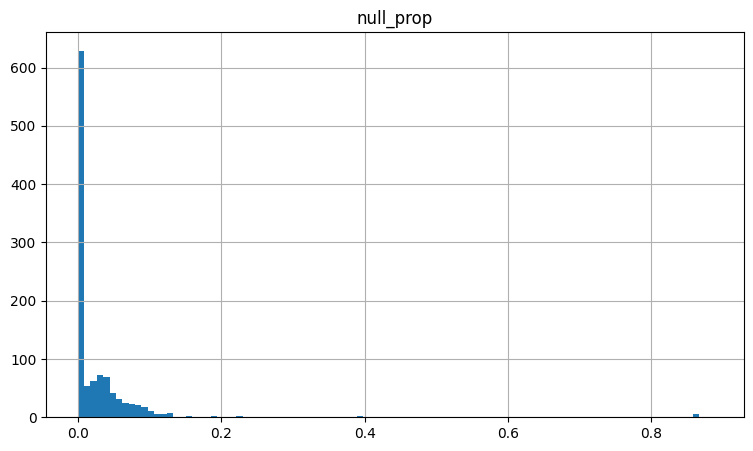

In [22]:
null_props.to_pandas().set_index('symbol').hist(bins=100)

array([[<Axes: title={'center': 'null_prop'}>]], dtype=object)

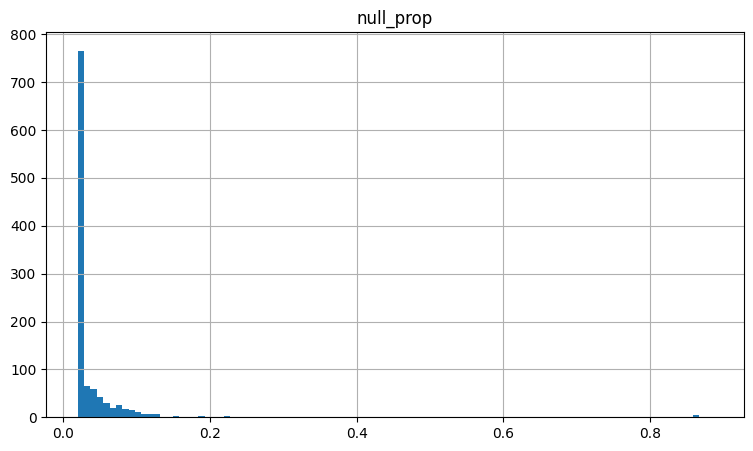

In [23]:
null_props.to_pandas().set_index('symbol').clip(max_null_prop).hist(bins=100)

In [24]:
cleaner_wo_weekends = (
    cleaner_wo_weekends
    .filter(null_prop.over(keys[1]) <= 0.02)
)

AGI


<Figure size 900x500 with 0 Axes>

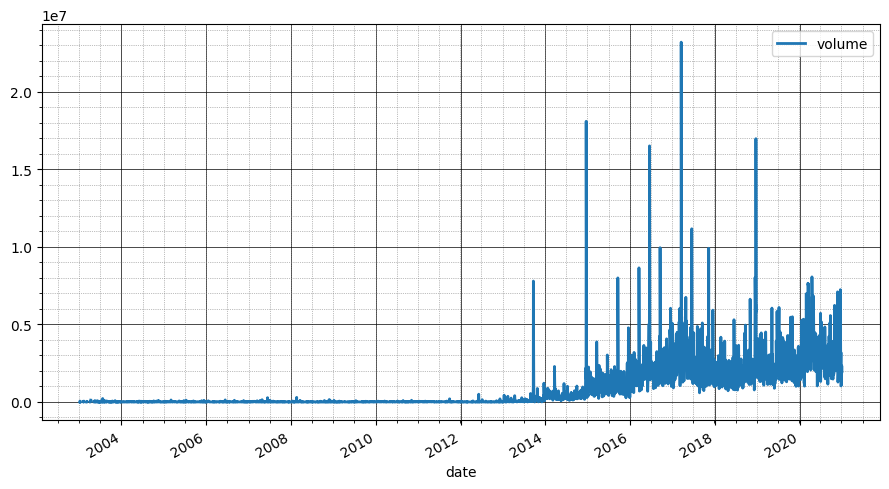

****************************************************************************************************
AIF


<Figure size 900x500 with 0 Axes>

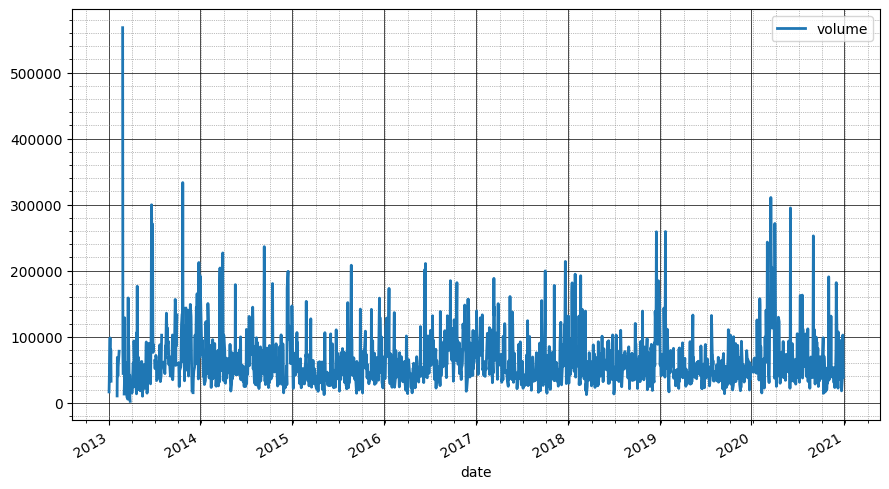

****************************************************************************************************
CYH


<Figure size 900x500 with 0 Axes>

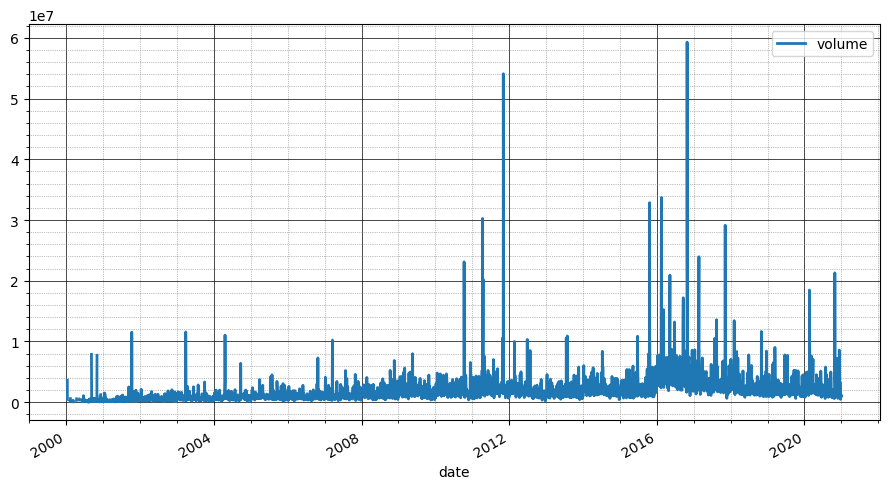

****************************************************************************************************
WES


<Figure size 900x500 with 0 Axes>

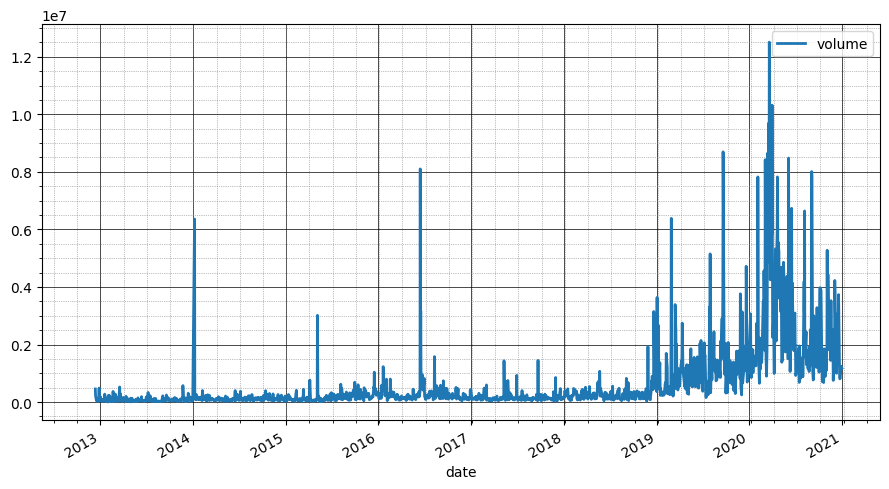

****************************************************************************************************
PNNT


<Figure size 900x500 with 0 Axes>

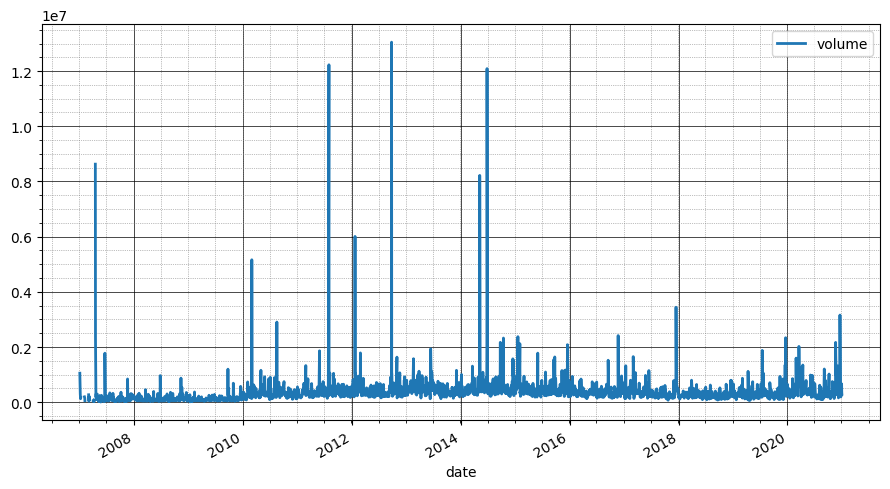

****************************************************************************************************
HII


<Figure size 900x500 with 0 Axes>

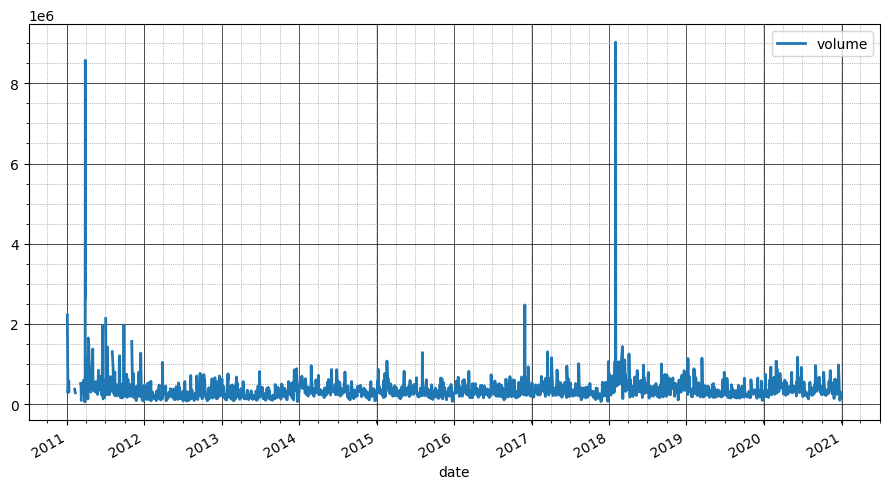

****************************************************************************************************
AOD


<Figure size 900x500 with 0 Axes>

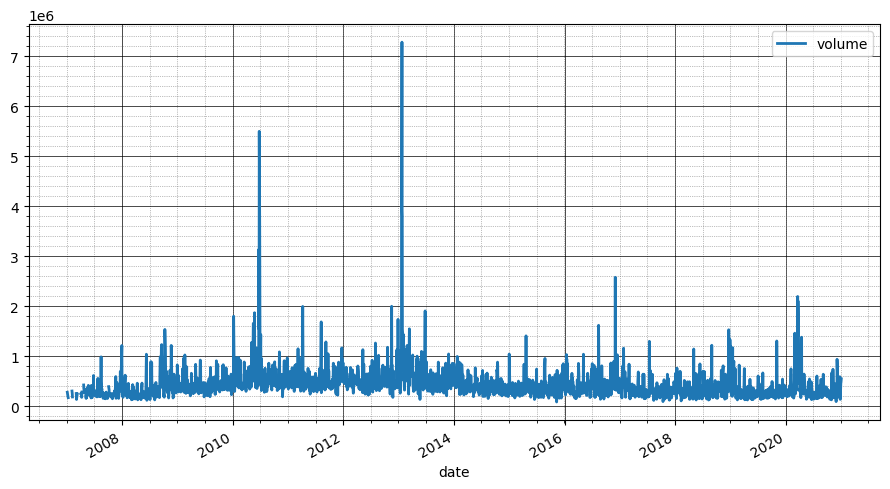

****************************************************************************************************
EPR-PE


<Figure size 900x500 with 0 Axes>

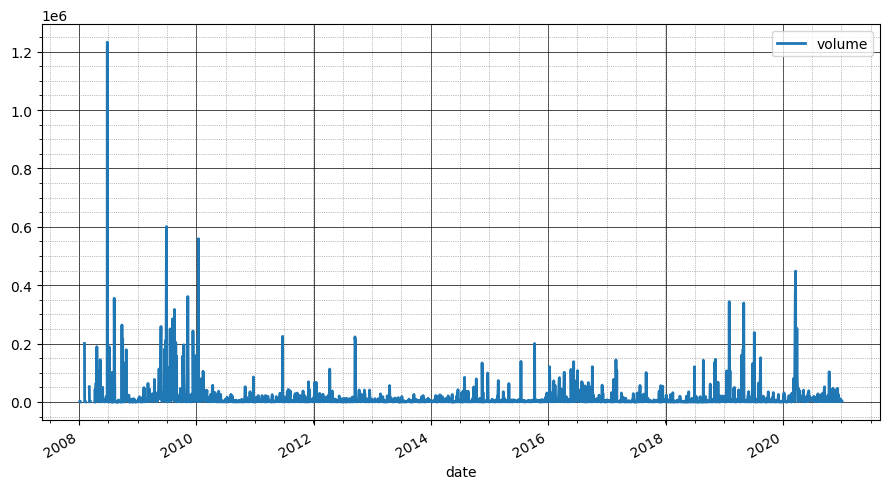

****************************************************************************************************
CUPUF


<Figure size 900x500 with 0 Axes>

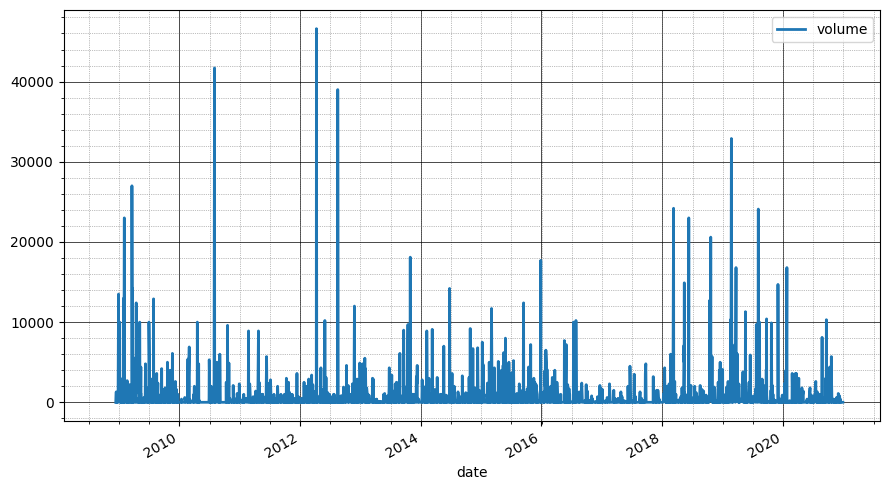

****************************************************************************************************
EDD


<Figure size 900x500 with 0 Axes>

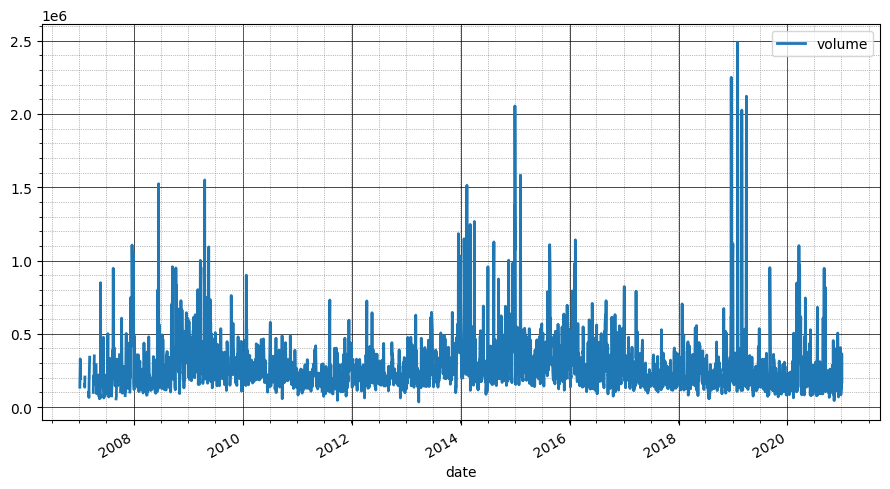

****************************************************************************************************


In [25]:
worst = (
    cleaner_wo_weekends
    .with_columns(null_prop=null_prop.over(keys[1]))
    .sort('null_prop', 'symbol', 'date')
)
for symbol in worst.get_column('symbol').unique(maintain_order=True).tail(10):
    print(symbol)
    sub = cleaner_wo_weekends.filter(pl.col('symbol') == symbol)
    plot_ts(sub, keys[0])
    print('*' * 100)

## Plot stocks with most variant demeaned volume

In [26]:
variances = (
    cleaner_wo_weekends
    .with_columns(mean=pl.col('volume').rolling_mean(window_size=225 // 12).over(keys[1]))
    .with_columns(pl.col('volume') - pl.col('mean'))
    .group_by(keys[1])
    .agg(variance=pl.col('volume').std())
    .sort('variance')
)
variances.describe()

shape: (9, 3)
┌────────────┬────────┬───────────────┐
│ statistic  ┆ symbol ┆ variance      │
│ ---        ┆ ---    ┆ ---           │
│ str        ┆ str    ┆ f64           │
╞════════════╪════════╪═══════════════╡
│ count      ┆ 695    ┆ 695.0         │
│ null_count ┆ 0      ┆ 0.0           │
│ mean       ┆ null   ┆ 928202.401576 │
│ std        ┆ null   ┆ 1.9395e6      │
│ min        ┆ AAT    ┆ 31.943144     │
│ 25%        ┆ null   ┆ 83308.150411  │
│ 50%        ┆ null   ┆ 305935.347887 │
│ 75%        ┆ null   ┆ 955522.371109 │
│ max        ┆ ZNH    ┆ 2.4634e7      │
└────────────┴────────┴───────────────┘

In [27]:
high_variances = (
    variances
    .filter((pl.col('variance') > 2) | pl.col('variance').is_null())
)
len(high_variances)

695

<Figure size 900x500 with 0 Axes>

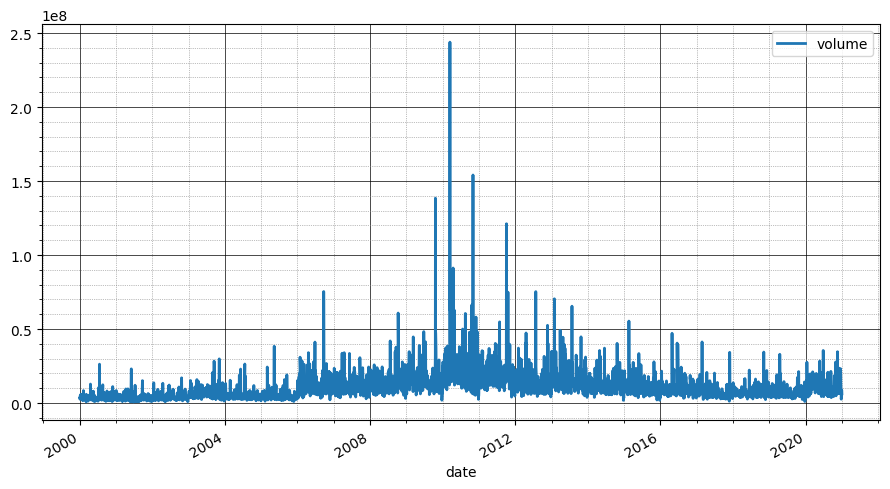

<Figure size 900x500 with 0 Axes>

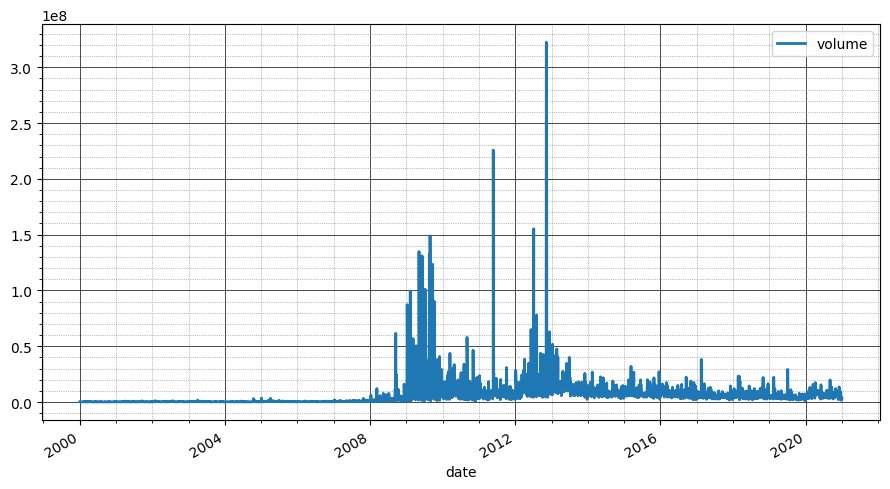

<Figure size 900x500 with 0 Axes>

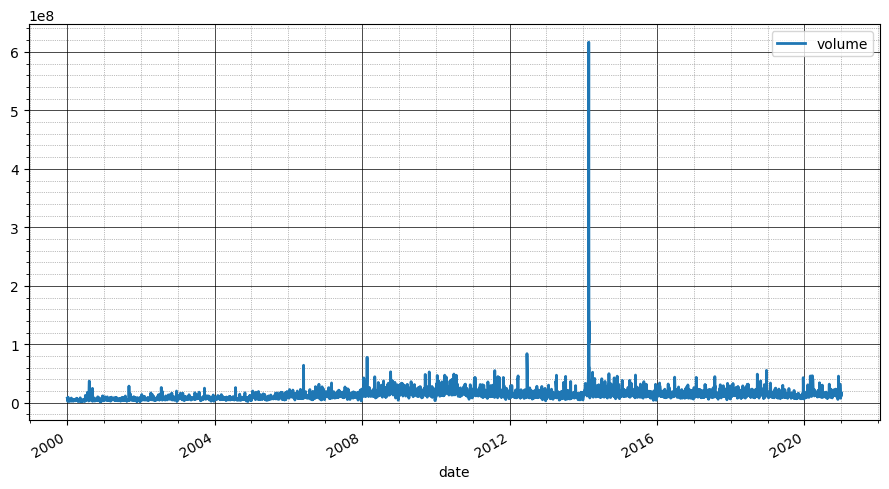

<Figure size 900x500 with 0 Axes>

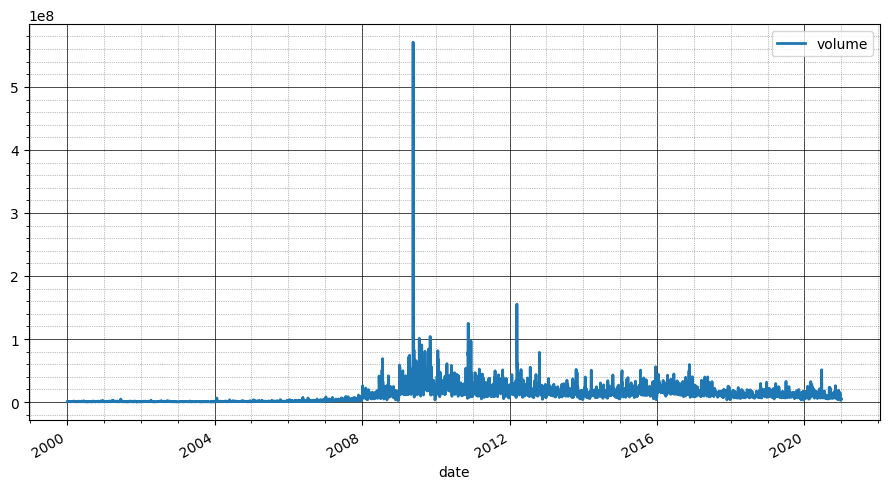

<Figure size 900x500 with 0 Axes>

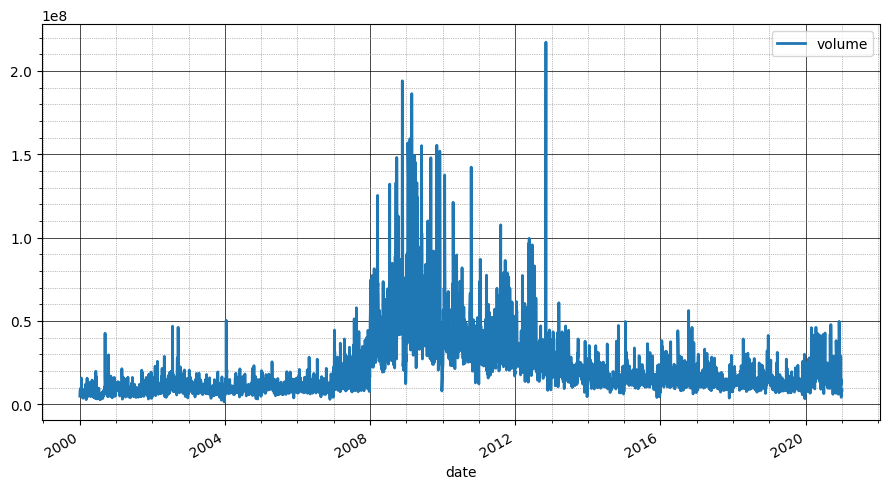

<Figure size 900x500 with 0 Axes>

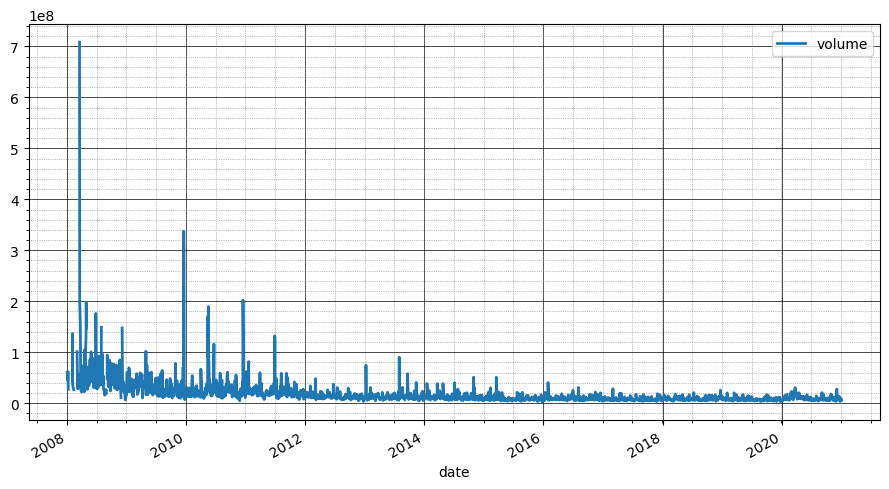

<Figure size 900x500 with 0 Axes>

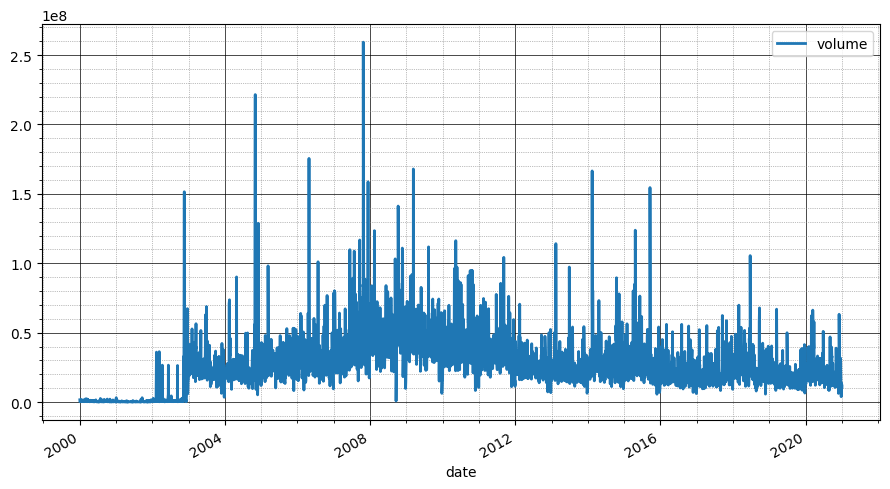

<Figure size 900x500 with 0 Axes>

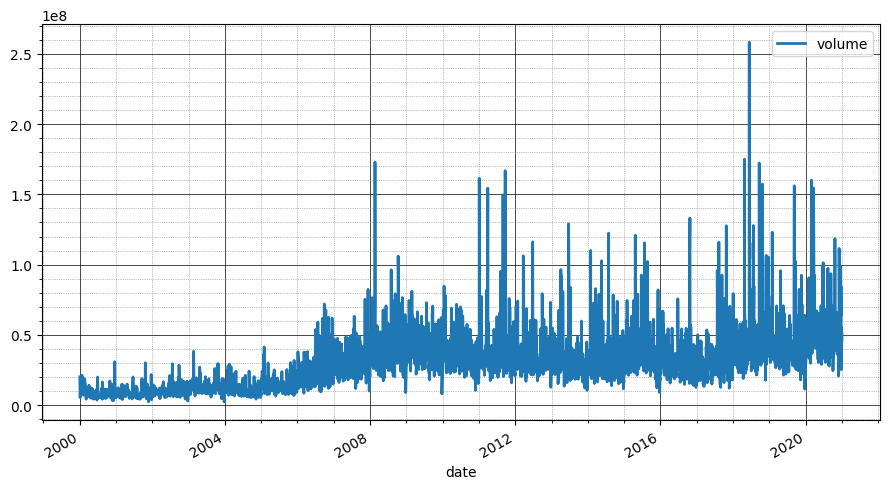

<Figure size 900x500 with 0 Axes>

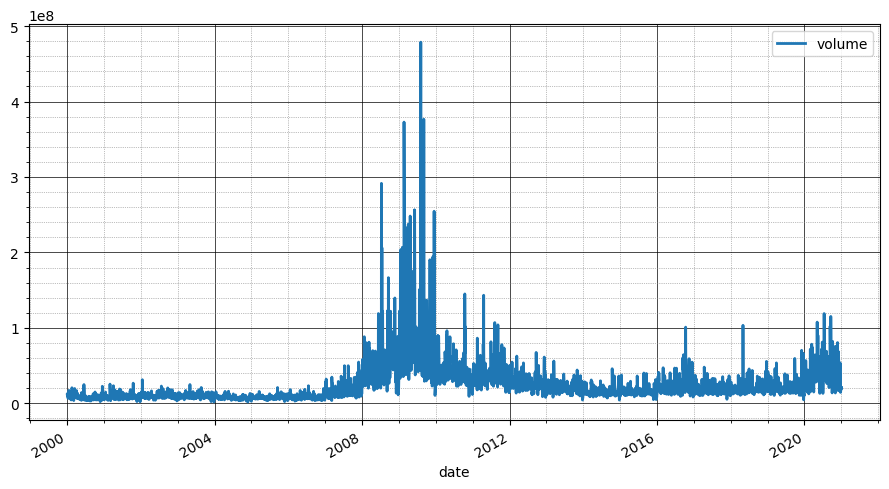

<Figure size 900x500 with 0 Axes>

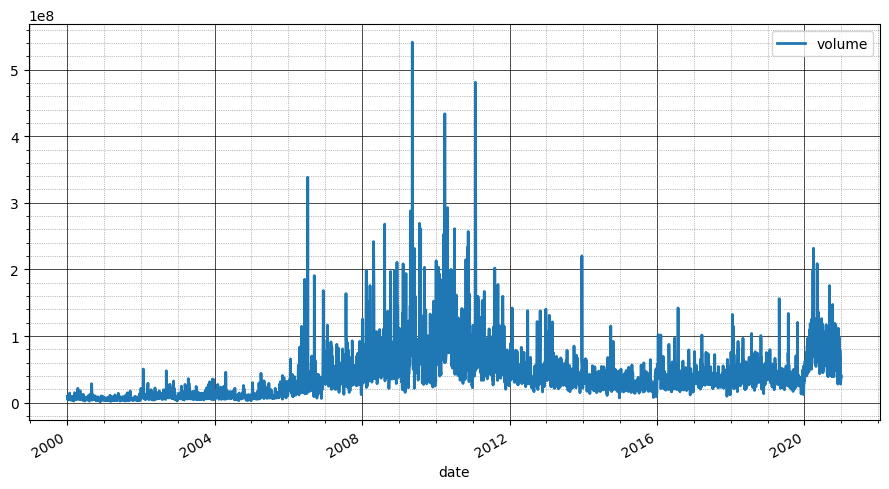

In [28]:
for symbol in high_variances.tail(10).get_column(keys[1]):
    plot_ts(cleaner_wo_weekends.filter(pl.col(keys[1]) == symbol), keys[0])

<Figure size 900x500 with 0 Axes>

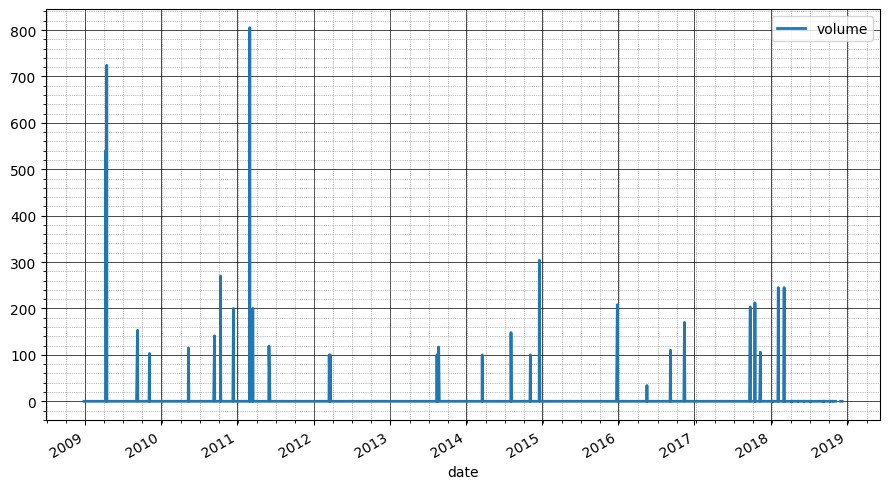

<Figure size 900x500 with 0 Axes>

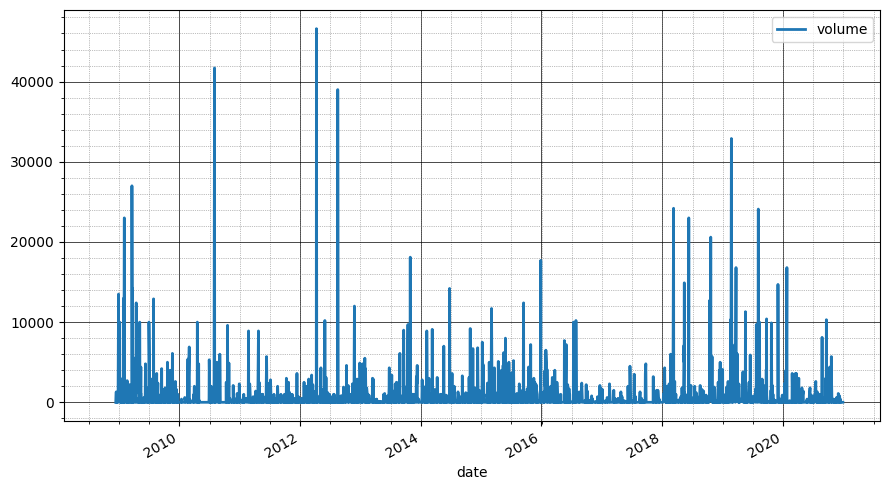

<Figure size 900x500 with 0 Axes>

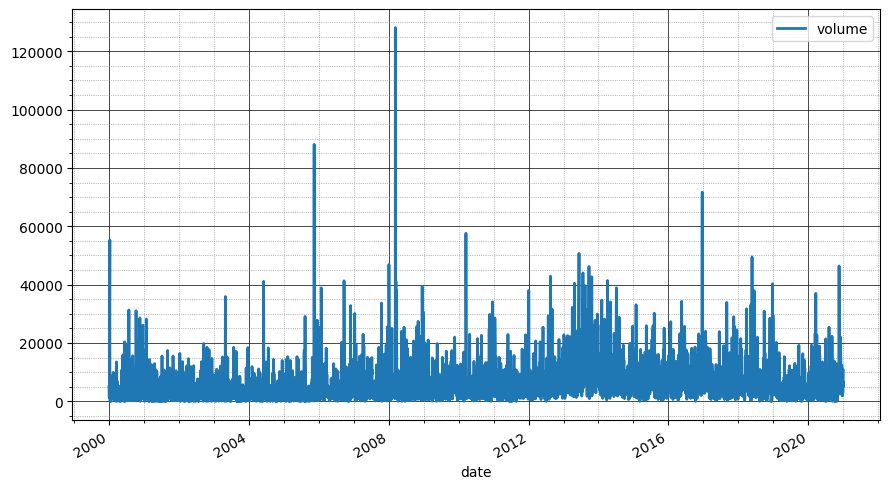

<Figure size 900x500 with 0 Axes>

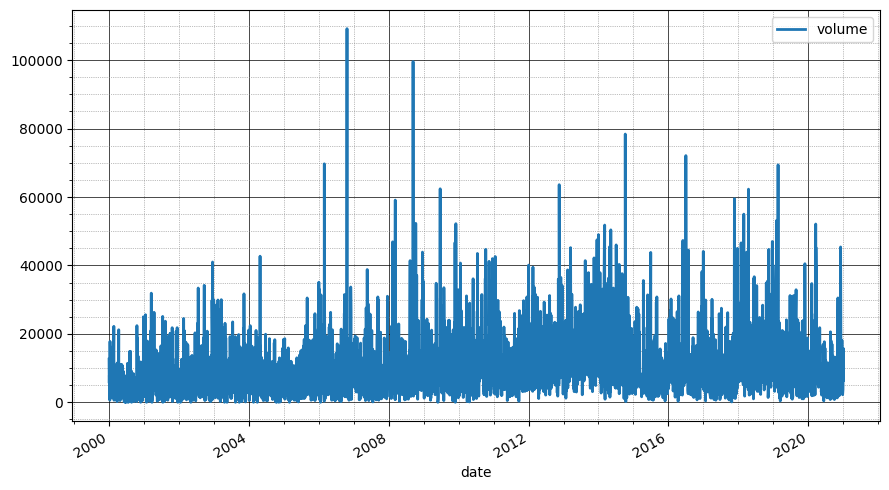

<Figure size 900x500 with 0 Axes>

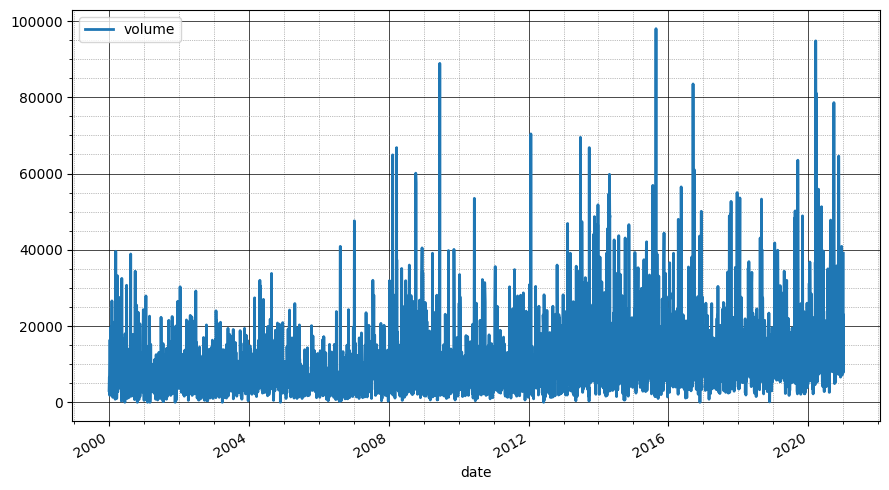

<Figure size 900x500 with 0 Axes>

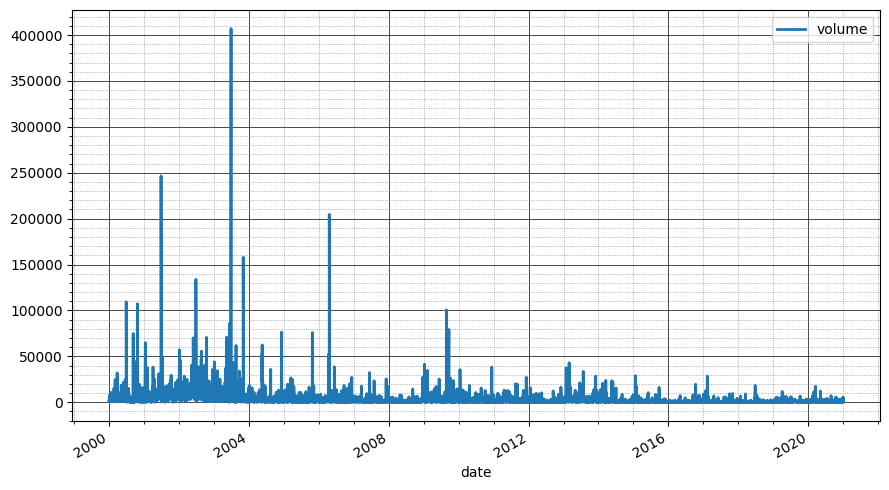

<Figure size 900x500 with 0 Axes>

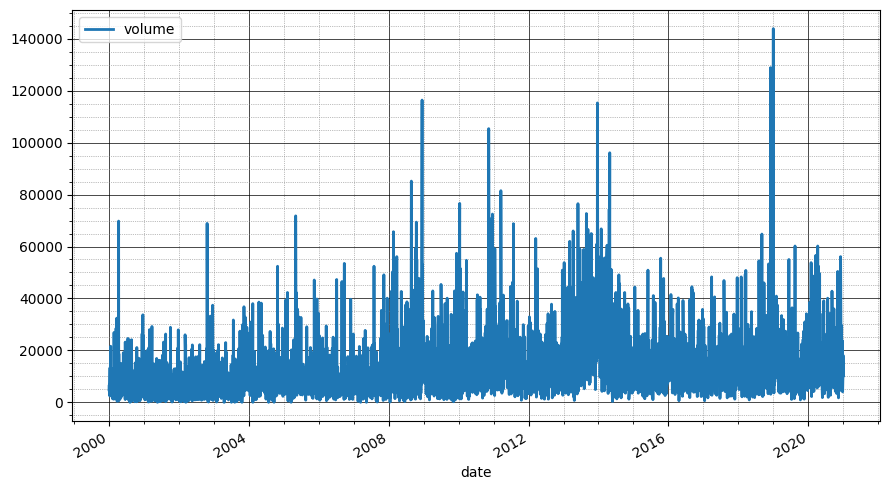

<Figure size 900x500 with 0 Axes>

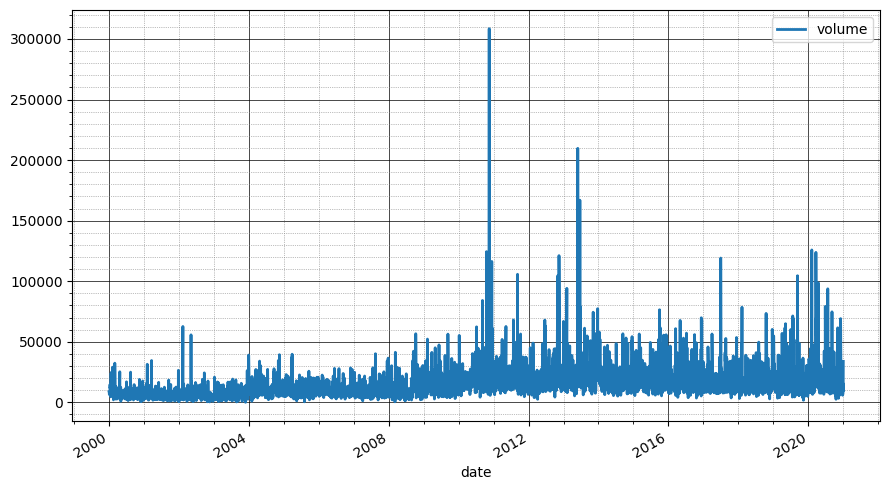

<Figure size 900x500 with 0 Axes>

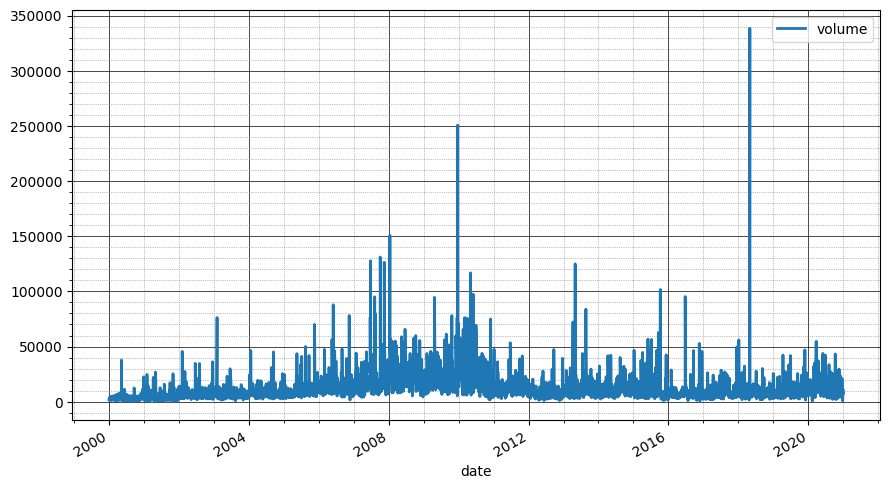

<Figure size 900x500 with 0 Axes>

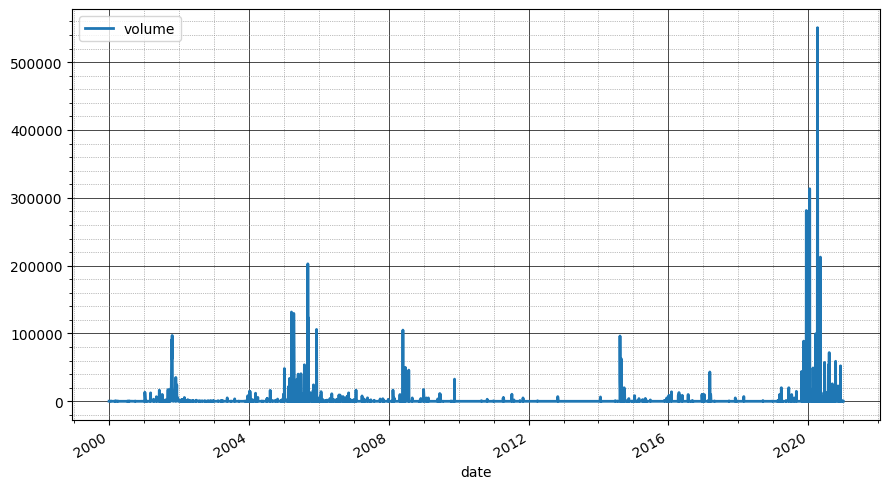

In [29]:
for symbol in high_variances.head(10).get_column(keys[1]):
    plot_ts(cleaner_wo_weekends.filter(pl.col(keys[1]) == symbol), keys[0])

## Returns

In [30]:
returns = (
    cleaner_wo_weekends
    .select(*keys, pl.col('volume').pct_change().over(keys[1]).alias('return'))
)
returns.describe()

shape: (9, 4)
┌────────────┬────────────┬─────────┬────────────┐
│ statistic  ┆ date       ┆ symbol  ┆ return     │
│ ---        ┆ ---        ┆ ---     ┆ ---        │
│ str        ┆ str        ┆ str     ┆ f64        │
╞════════════╪════════════╪═════════╪════════════╡
│ count      ┆ 3045790    ┆ 3045790 ┆ 3.045095e6 │
│ null_count ┆ 0          ┆ 0       ┆ 695.0      │
│ mean       ┆ 2010-12-15 ┆ null    ┆ NaN        │
│ std        ┆ null       ┆ null    ┆ NaN        │
│ min        ┆ 2000-01-03 ┆ AAT     ┆ -1.0       │
│ 25%        ┆ 2005-11-16 ┆ null    ┆ -0.305015  │
│ 50%        ┆ 2011-03-14 ┆ null    ┆ -0.003195  │
│ 75%        ┆ 2016-02-16 ┆ null    ┆ 0.440529   │
│ max        ┆ 2020-12-31 ┆ ZNH     ┆ NaN        │
└────────────┴────────────┴─────────┴────────────┘

In [31]:
high_returns = (
    returns
    .filter(pl.col('return').abs() > 0.5)
    .group_by(keys[1])
    .agg(pl.col('return').abs().max())
    .sort(pl.col('return').abs())
)
len(high_returns)

695

<Figure size 900x500 with 0 Axes>

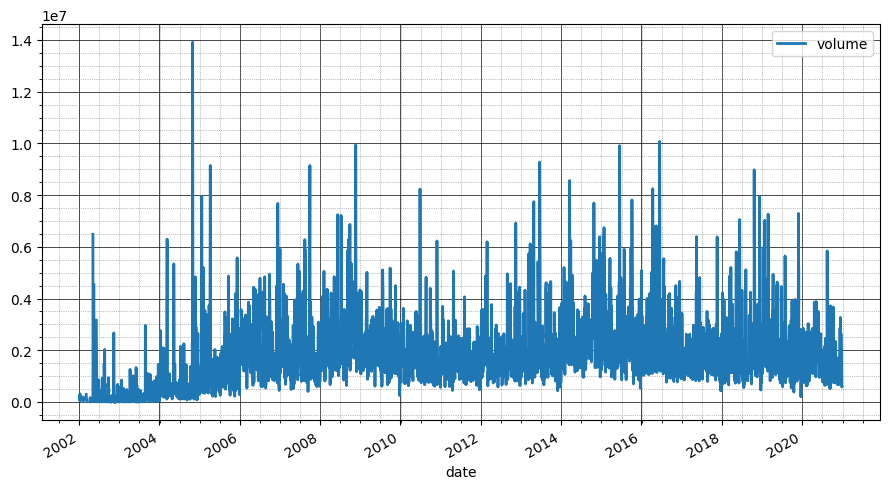

<Figure size 900x500 with 0 Axes>

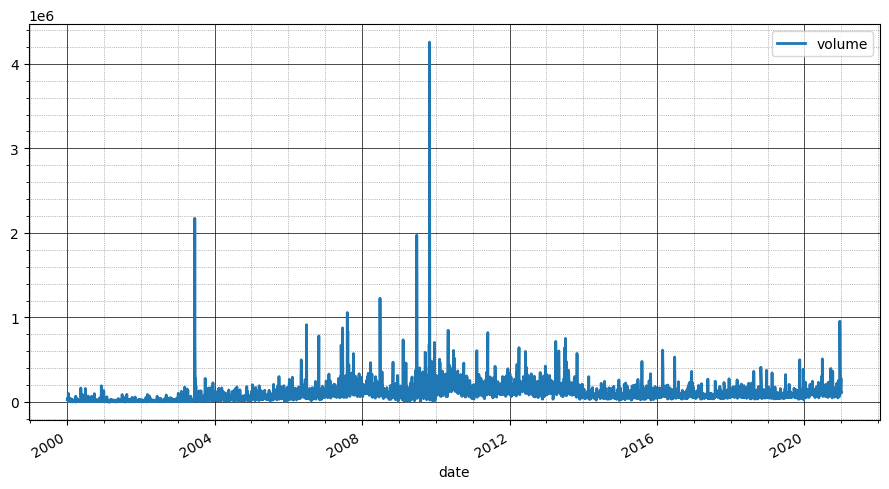

<Figure size 900x500 with 0 Axes>

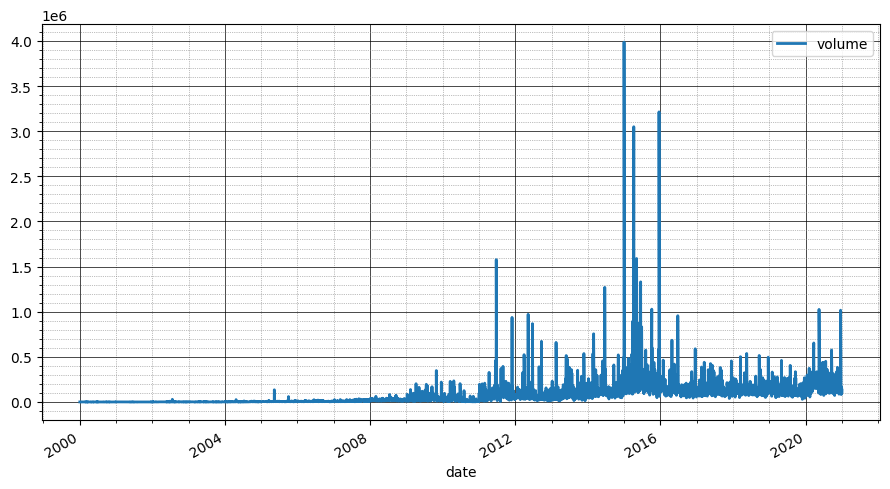

<Figure size 900x500 with 0 Axes>

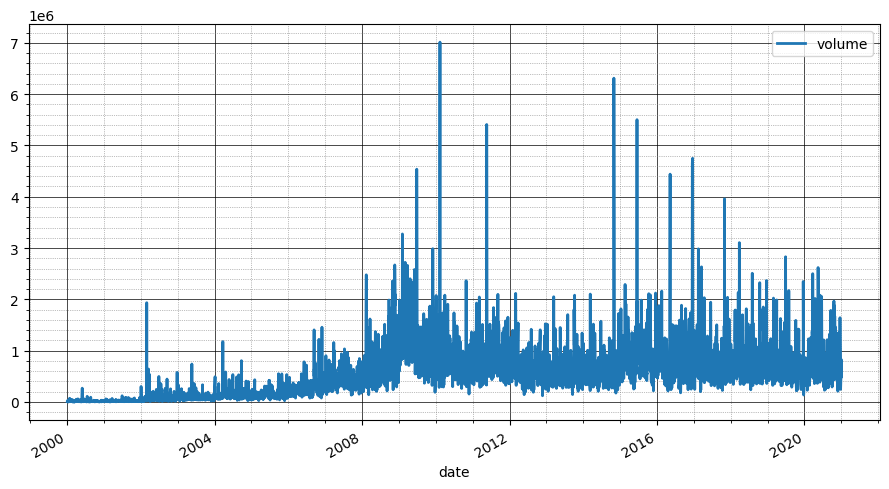

<Figure size 900x500 with 0 Axes>

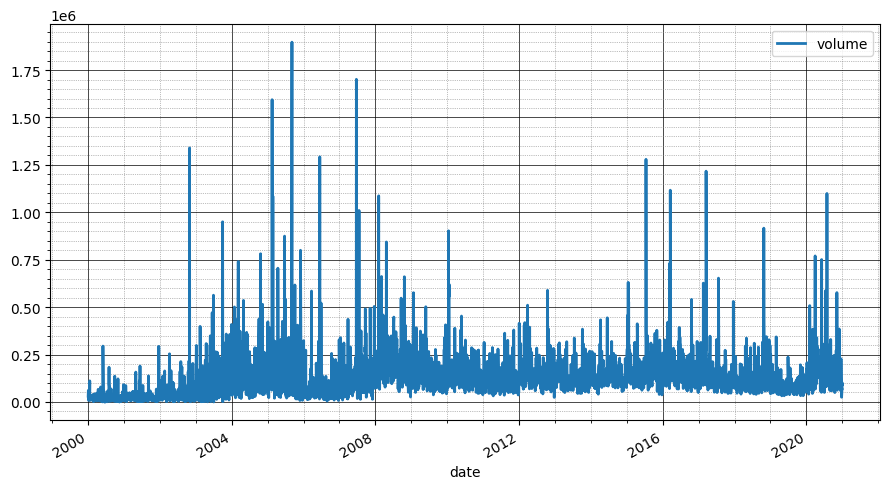

<Figure size 900x500 with 0 Axes>

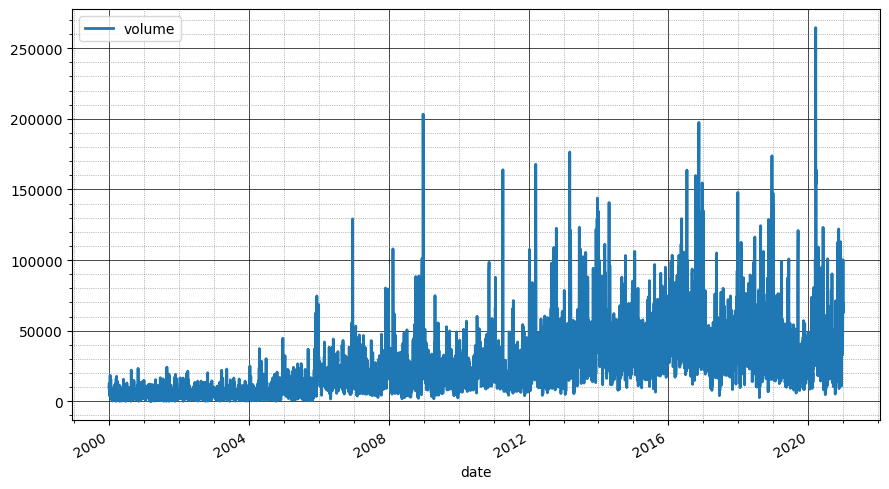

<Figure size 900x500 with 0 Axes>

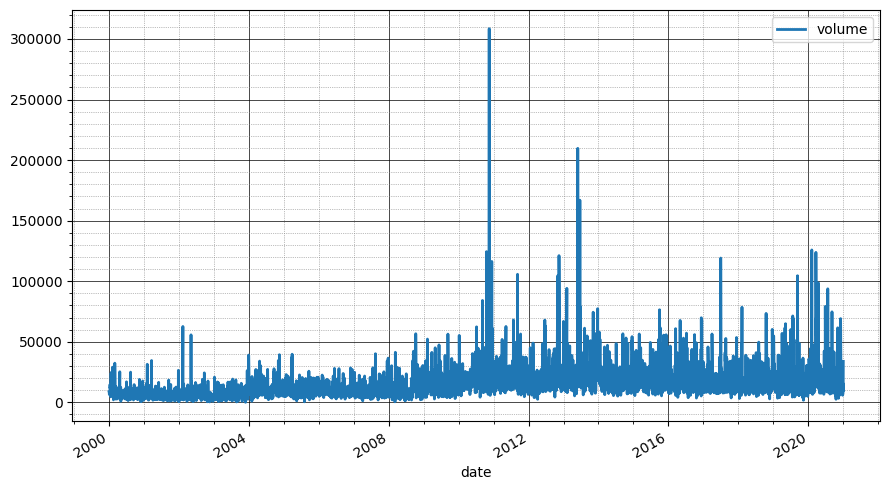

<Figure size 900x500 with 0 Axes>

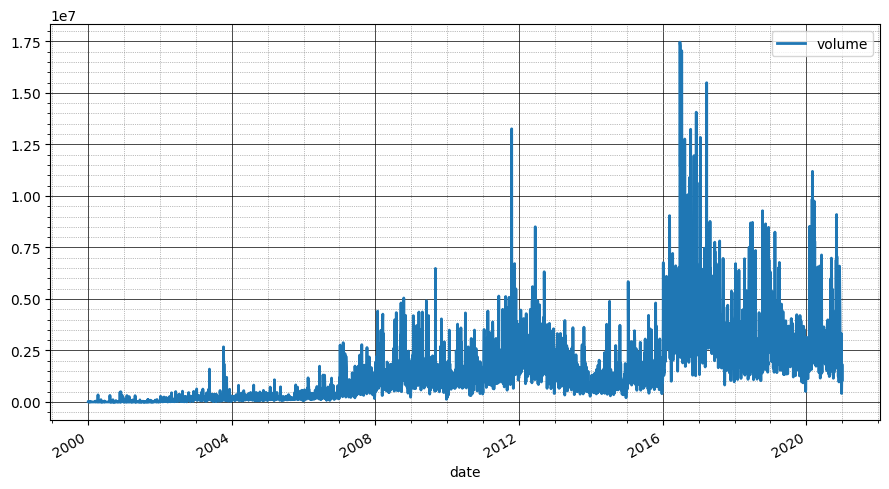

<Figure size 900x500 with 0 Axes>

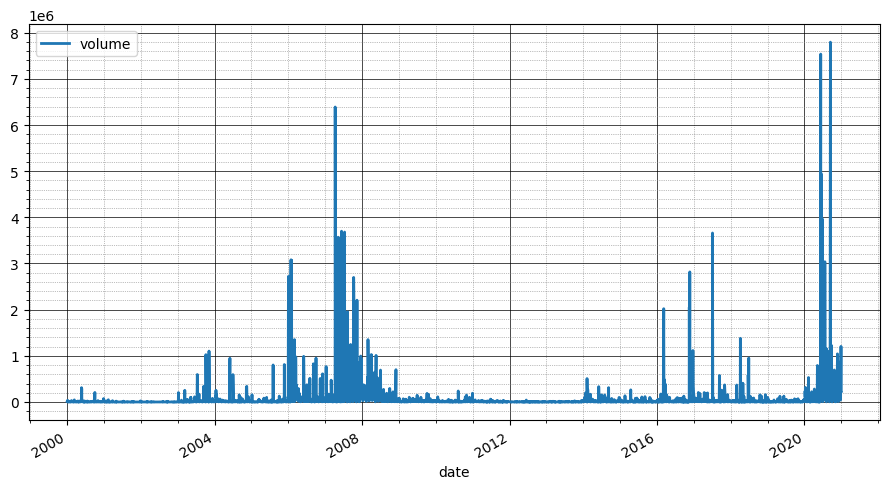

<Figure size 900x500 with 0 Axes>

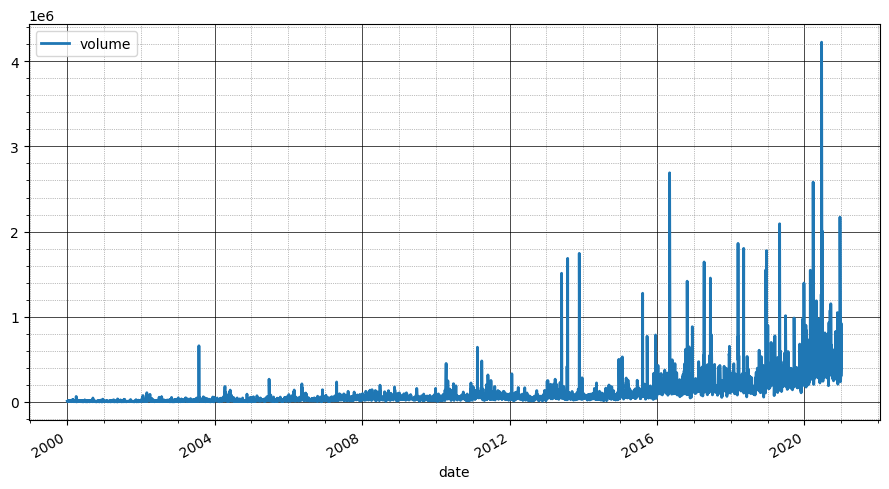

In [32]:
for symbol in high_returns.tail(10).get_column(keys[1]):
    plot_ts(cleaner_wo_weekends.filter(pl.col(keys[1]) == symbol), keys[0])

<Figure size 900x500 with 0 Axes>

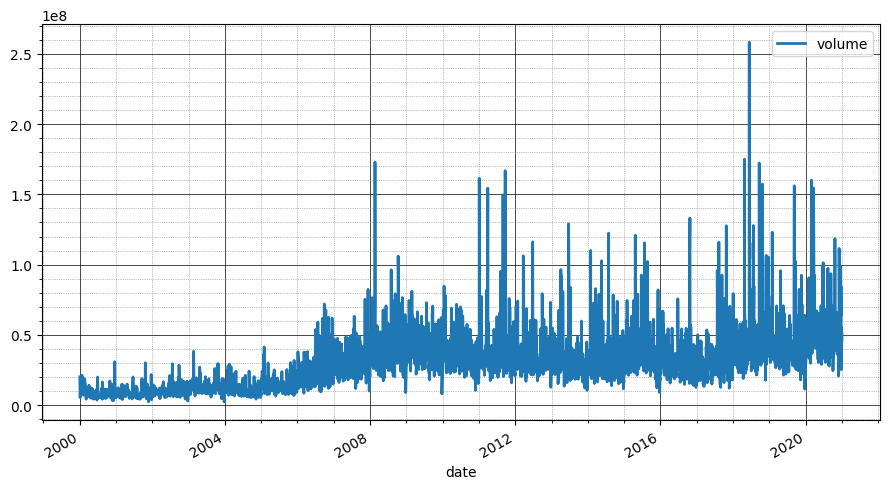

<Figure size 900x500 with 0 Axes>

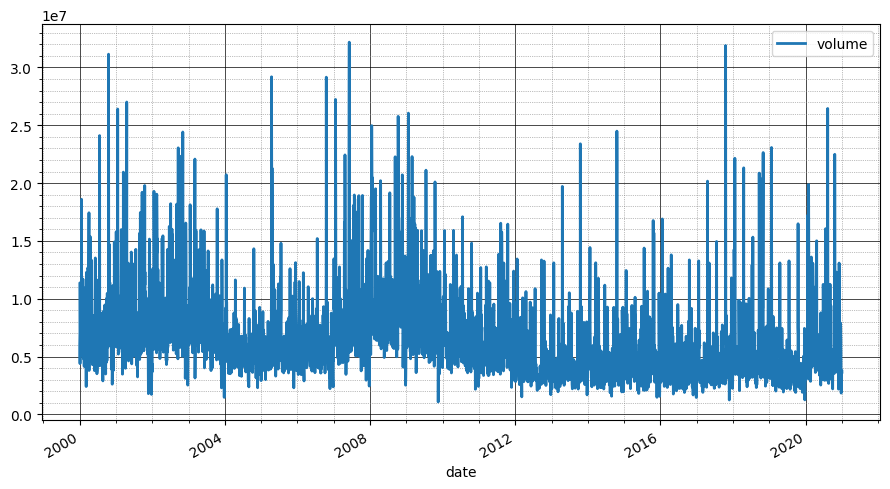

<Figure size 900x500 with 0 Axes>

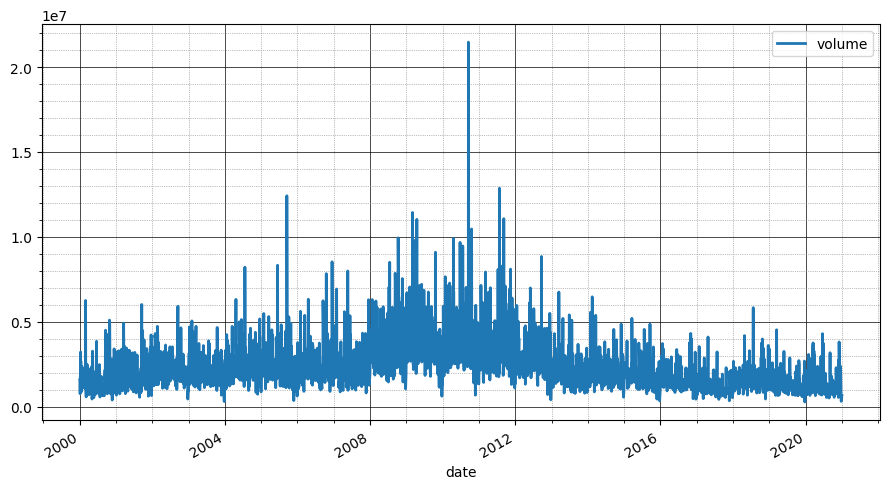

<Figure size 900x500 with 0 Axes>

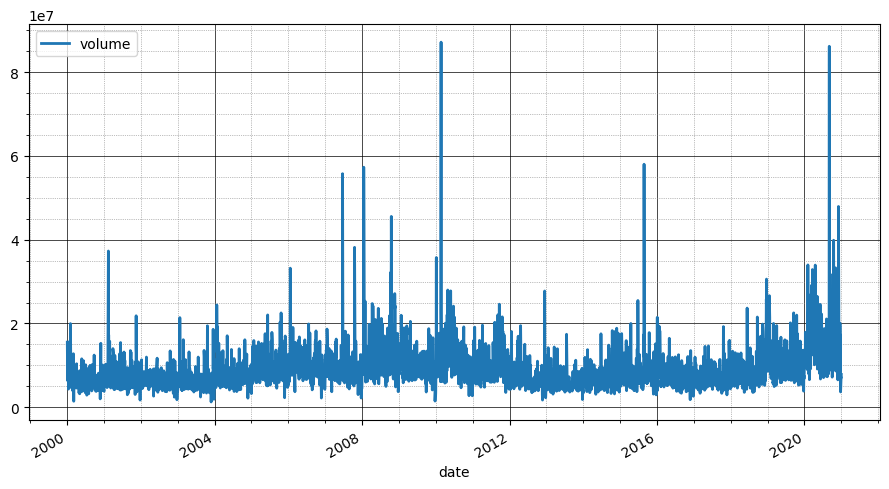

<Figure size 900x500 with 0 Axes>

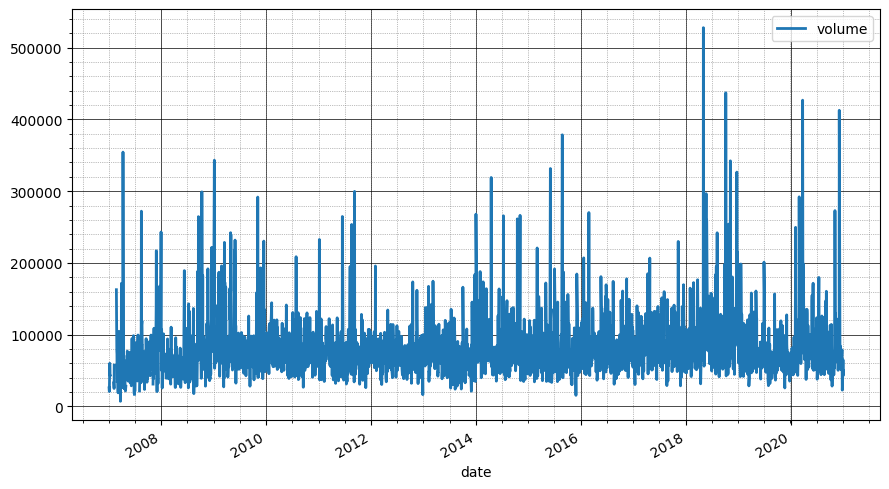

<Figure size 900x500 with 0 Axes>

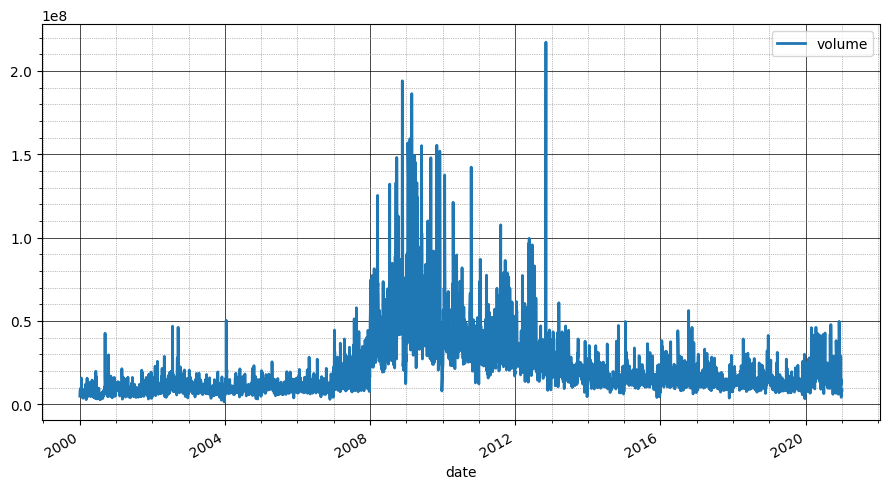

<Figure size 900x500 with 0 Axes>

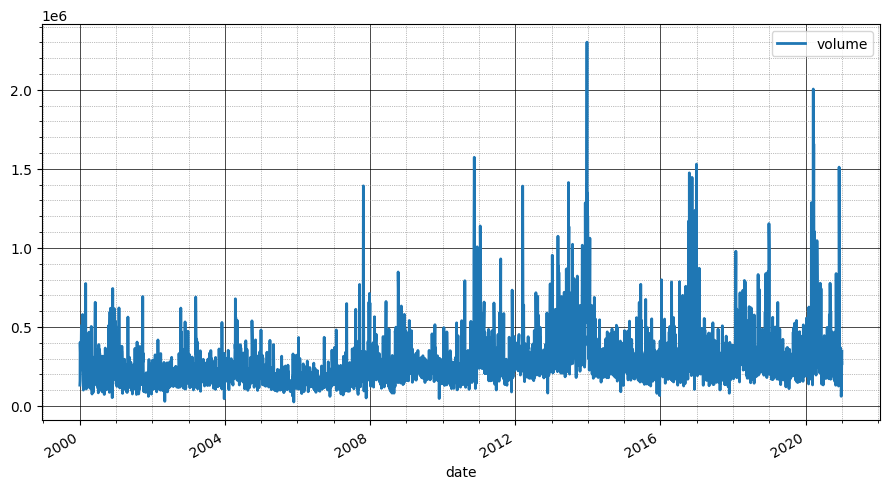

<Figure size 900x500 with 0 Axes>

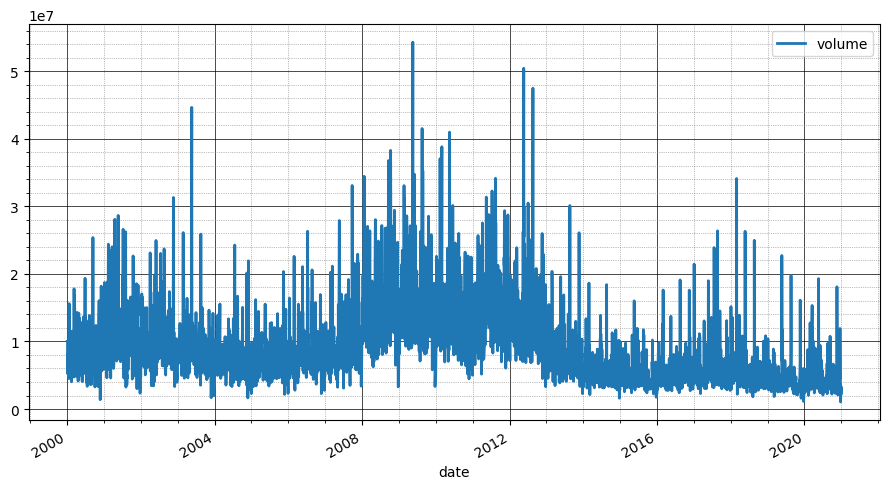

<Figure size 900x500 with 0 Axes>

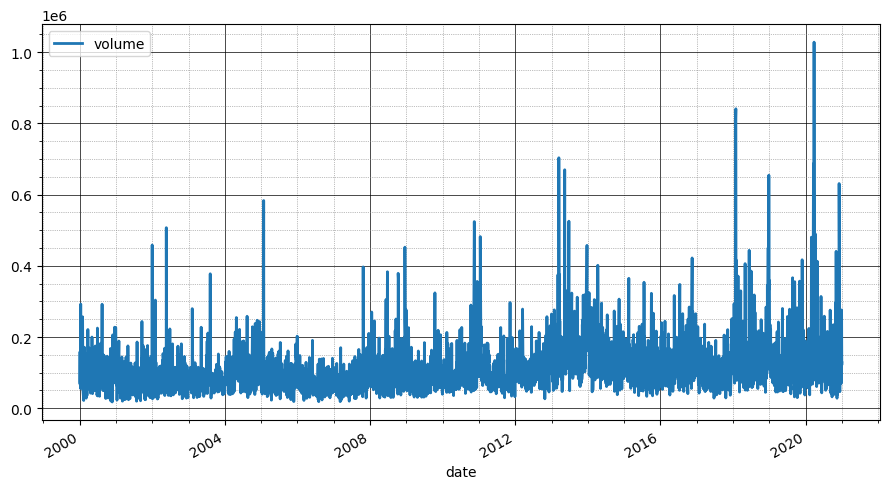

<Figure size 900x500 with 0 Axes>

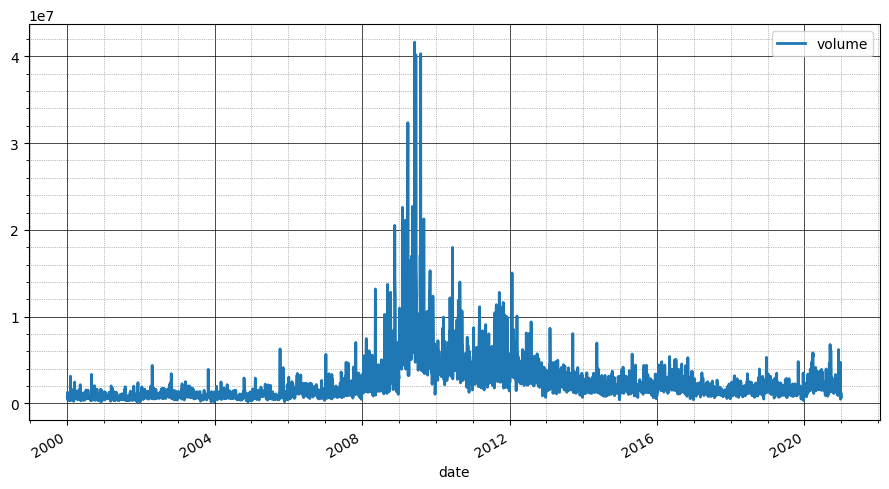

In [33]:
for symbol in high_returns.head(10).get_column(keys[1]):
    plot_ts(cleaner_wo_weekends.filter(pl.col(keys[1]) == symbol), keys[0])

<Axes: >

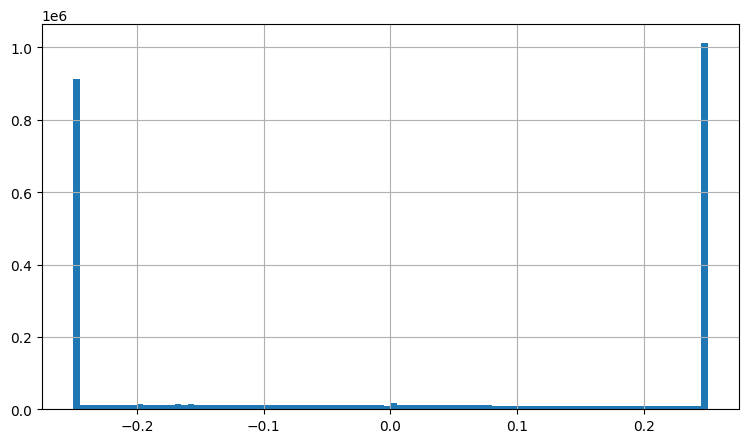

In [34]:
returns.to_pandas()['return'].clip(-0.25, 0.25).hist(bins=100)

## Is there good data?

In [35]:
stats = (
    cleaner_wo_weekends
    .with_columns(
        pl.col('volume').pct_change().over(keys[1]).alias('return'),
        pl.col('volume').rolling_mean(window_size=225 // 12).over(keys[1]).alias('mean')
    )
    .with_columns(pl.col('volume') - pl.col('mean'))
    .group_by(keys[1])
    .agg([
        pl.col('volume').std().alias('variance'),
        pl.col('return').abs().max().alias('max_return'),
        pl.col('volume').null_count().alias('null_count')
    ])
)
okk = (
    stats
    .filter(pl.col('variance') < 2)
    .filter(pl.col('max_return') < 1)
    .sort('variance', 'max_return', 'null_count')
)
okk

shape: (0, 4)
┌────────┬──────────┬────────────┬────────────┐
│ symbol ┆ variance ┆ max_return ┆ null_count │
│ ---    ┆ ---      ┆ ---        ┆ ---        │
│ str    ┆ f64      ┆ f64        ┆ u32        │
╞════════╪══════════╪════════════╪════════════╡
└────────┴──────────┴────────────┴────────────┘

In [36]:
for symbol in okk.head(10).get_column(keys[1]):
    plot_ts(cleaner_wo_weekends.filter(pl.col(keys[1]) == symbol), keys[0])

In [37]:
for symbol in okk.tail(10).get_column(keys[1]):
    plot_ts(cleaner_wo_weekends.filter(pl.col(keys[1]) == symbol), keys[0])

## Back to _wo_weekends and save

In [38]:
symbols = cleaner_wo_weekends.select(pl.col('symbol').unique())
cleaner = symbols.join(cleaner, on='symbol', how='inner')

In [39]:
cleaner.select(pl.col('date').n_unique(), pl.col('symbol').n_unique())

shape: (1, 2)
┌──────┬────────┐
│ date ┆ symbol │
│ ---  ┆ ---    │
│ u32  ┆ u32    │
╞══════╪════════╡
│ 5284 ┆ 695    │
└──────┴────────┘

In [40]:
# cleaner.write_parquet('cleaner.parquet')

In [41]:
cleaner_wo_weekends.select(pl.col('date').n_unique(), pl.col('symbol').n_unique())

shape: (1, 2)
┌──────┬────────┐
│ date ┆ symbol │
│ ---  ┆ ---    │
│ u32  ┆ u32    │
╞══════╪════════╡
│ 4709 ┆ 695    │
└──────┴────────┘

In [42]:
# cleaner_wo_weekends.write_parquet('cleaner_wo_weekends.parquet')